<a href="https://colab.research.google.com/github/onni-Q/workshop_notebooks/blob/main/Week5_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Keep cell -> only run once, then comment all

!pip install pytesseract > /dev/null
!pip install --upgrade easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 21.9 MB/s eta 0:00:00


In [ ]:
# Import required libraries and set a cache for the models so they load faster.
# You'll have to allow access to Drive for this.

import os
from google.colab import drive
drive.mount('/content/drive')
CACHE_DIR = "/content/drive/MyDrive/CDA-CACHE/huggingface"
os.makedirs(CACHE_DIR, exist_ok=True) # Create the folder if it doesn't exist
os.environ['HF_HOME'] = CACHE_DIR
os.environ['TRANSFORMERS_CACHE'] = CACHE_DIR
# Alternatively, for older transformers versions: os.environ['TRANSFORMERS_CACHE'] = CACHE_DIR
print(f"Hugging Face cache directory set to: {os.environ.get('HF_HOME')}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, pipeline

# Get the test images for the week
if not(os.path.exists('test_data')):
  print('Downloading week 5 images \n')
  !mkdir test_data
  !wget https://github.com/delfimpandiani/cultural-data-analysis-CDAI/raw/refs/heads/main/week5_imgs.zip
  !unzip -q week5_imgs -d test_data
  !rm week5_imgs.zip

Mounted at /content/drive
Hugging Face cache directory set to: /content/drive/MyDrive/CDA-CACHE/huggingface


/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(



--2025-10-30 17:23:34--  https://github.com/delfimpandiani/cultural-data-analysis-CDAI/raw/refs/heads/main/week5_imgs.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/delfimpandiani/cultural-data-analysis-CDAI/refs/heads/main/week5_imgs.zip [following]
--2025-10-30 17:23:34--  https://raw.githubusercontent.com/delfimpandiani/cultural-data-analysis-CDAI/refs/heads/main/week5_imgs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22959834 (22M) [application/zip]
Saving to: ‘week5_imgs.zip’

week5_imgs.zip      100%[===================>]  21.90M  --.-KB/s    in 0.06s   

2025-10-30 17:23:34 (

# Seminar Notebook - Week 5 — Image Processing and Computer Vision

In this workshop, we’ll explore classical and deep computer vision (CV) techniques — and think critically about their performance on historical photography.

🎯 Objectives

- Practice classical CV: filtering, contour detection, and feature matching.
- Apply deep CV: image classification (CNNs & ViTs) and object detection.
- Introduce Visual–Language Models (VLMs) for captioning and multimodal understanding.
- Critically reflect on applying CV models to 19th-century archival imagery

## 📸 Context: Amsterdam City Archives' Kabinetfotos

The images used here come from the [Amsterdam City Archives’ Kabinetfotos collection](https://beta.archief.amsterdam/detail/b554d686-cd69-6385-e053-b784100a1322). In 1867, the cabinet format (11 × 16 cm) became popular in portrait studios. Soon after, cityscapes of this size were also produced for the tourist market. The archive holds ~2,000 photographs from 1867–1910, an invaluable record of Amsterdam’s visual history.

Keep in mind: these 19th-century photos differ greatly from the modern datasets used to train most CV models. This is intentional — part of today’s goal is to reflect on the limits of pretrained models when applied to historical material.

The 10 images we will be using are copyright-free and documented here:

- https://beta.archief.amsterdam/detail/e8f54fcc-1445-cc71-c2c2-13f29b2a1834
- https://beta.archief.amsterdam/detail/e9de21fd-ca33-a1f8-bc71-fae593bce63c
- https://beta.archief.amsterdam/detail/e557c10e-9c4f-7dcb-e053-b784100a971b
- https://beta.archief.amsterdam/detail/ea7ef6a5-2436-a1d7-f70a-00b309a47f16
- https://beta.archief.amsterdam/detail/8980f915-046a-8958-7e29-0b6e454aa91b
- https://beta.archief.amsterdam/detail/ca9e1df9-c064-050d-8f5c-7e4aa6bbe9f3
- https://beta.archief.amsterdam/detail/d4b26642-e0d3-a184-b086-7a5a39f2408b
- https://beta.archief.amsterdam/detail/ba201345-6b1b-b717-04bf-84403dde531f
- https://beta.archief.amsterdam/detail/11ea3319-81e9-969d-9a4f-ef765abf2f06
- https://beta.archief.amsterdam/detail/2ccb6541-7a1a-e35d-8ec5-df01a2b4ba61

#### 🗓 Reminder:
We’ll meet at the Amsterdam City Archives on Friday — take note of interesting model outputs and bring your questions for the archivists!

## 1. Loading the images

Let’s start by verifying access to our 10 Kabinetfotos.

Define the directory containing the images and call it `img_dir`. Automatically build a dictionary mapping filenames to full paths. Then print the results.


In [ ]:
# Define the directory containing the images
img_dir = #YOUR CODE HERE

# Create a dictionary mapping image names (without extension) to file paths
image_paths = {}
for fname in os.listdir(img_dir):
    #YOUR CODE HERE

print("✅ Found images:")
for name, path in image_paths.items():
    print(f"{name}: {path}")


✅ Found images:
kabinet_7: /content/test_data/week5_imgs/seminar_imgs/kabinet_7.png
kabinet_5: /content/test_data/week5_imgs/seminar_imgs/kabinet_5.png
kaninet_10: /content/test_data/week5_imgs/seminar_imgs/kaninet_10.png
kabinet_4: /content/test_data/week5_imgs/seminar_imgs/kabinet_4.png
kabinet_8: /content/test_data/week5_imgs/seminar_imgs/kabinet_8.png
kabinet_3: /content/test_data/week5_imgs/seminar_imgs/kabinet_3.png
kabinet_6: /content/test_data/week5_imgs/seminar_imgs/kabinet_6.png
kabinet_2: /content/test_data/week5_imgs/seminar_imgs/kabinet_2.png
kabinet_1: /content/test_data/week5_imgs/seminar_imgs/kabinet_1.png
kabinet_9: /content/test_data/week5_imgs/seminar_imgs/kabinet_9.png


Now, let’s preview the 10 images, resizing each to a width of 400 pixels for easier viewing:

In [ ]:
for path in image_paths.values():
    #YOUR CODE HERE


## 2. Classical Computer Vision

### Filtering

Filtering is a fundamental image-processing step.
Apply the three filters discussed in the lecture — Blurring, Binary Thresholding, and Edge Detection — to one Kabinetfoto.

👉 *Remember: what step must you do before applying these filters?*

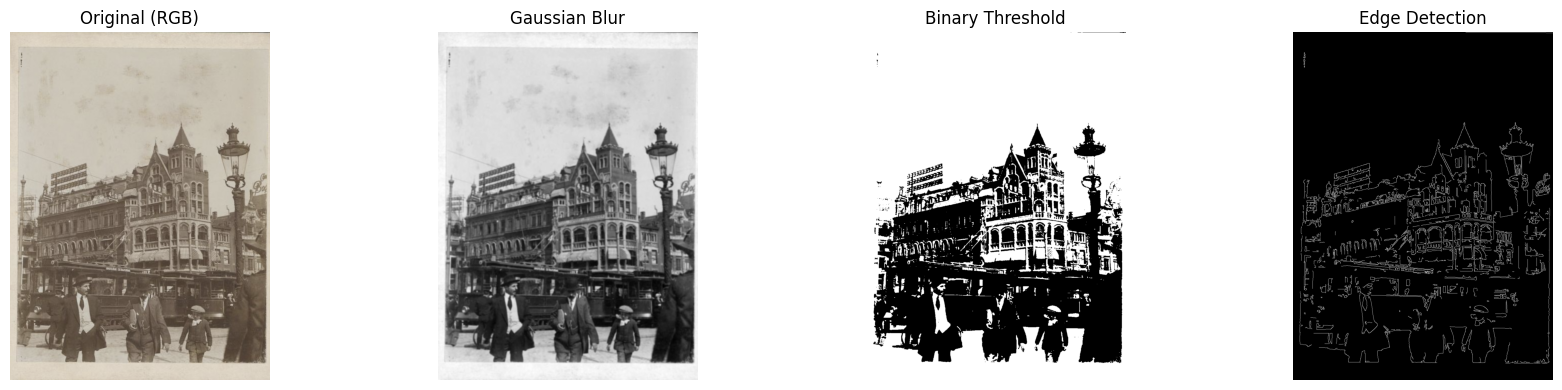

In [ ]:
#YOUR CODE HERE


# Display the transformations
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].imshow(cv_image_rgb)
axes[0].set_title("Original (RGB)")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Gaussian Blur")
axes[2].imshow(binary, cmap='gray')
axes[2].set_title("Binary Threshold")
axes[3].imshow(edges, cmap='gray')
axes[3].set_title("Edge Detection")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Contour detection

We also learned that contour detection is one of the earliest computer vision techniques. Apply it to the image.


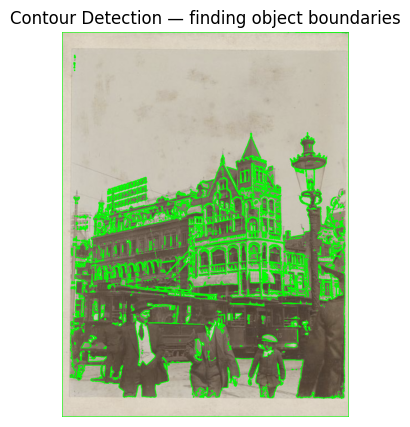

In [ ]:
#YOUR CODE HERE

# Display
plt.figure(figsize=(10, 5))
plt.imshow(contour_img)
plt.title("Contour Detection — finding object boundaries")
plt.axis('off')
plt.show()


### Feature Detection

Finally, perform feature detection to identify the msot **salient points** in the image.

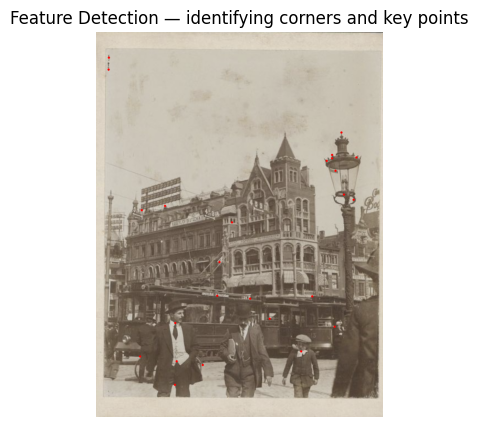

In [ ]:
#YOUR CODE HERE

# Display results
plt.figure(figsize=(10, 5))
plt.imshow(features_img)
plt.title("Feature Detection — identifying corners and key points")
plt.axis('off')
plt.show()


## 3. Deep Computer Vision Models

### Single-Label Classification with CNNs and ViTs

Now let’s classify our images using pretrained Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs).

Single-label classification assigns one predicted label per image — the class it most likely belongs to.
(In reality, an image may contain multiple objects or themes, which would require multi-label classification.)

Apply the technique, just like we did in the lecture notebook, to the 10 kabinetfotos.

In [ ]:
#YOUR CODE HERE


#### 💭 Critical Reflection: Image-Level Classification

Reflect on how CNN and ViT labels differ or overlap.
For example, kabinet_3 (a surgery room) might be classified as a restaurant or eatery — what might this reveal about training data biases? What about kabinet_10? Pick one image and write a short paragraph analyzing the predictions.

In [ ]:
# Your reflection here

### Object Detection

Now let’s detect multiple objects in an image, using a CNN- or transformer-based model (DETR, YOLO, etc.). Choose your model, explain why, and visualize bounding boxes for all Kabinetfotos.


In [ ]:
#YOUR CODE HERE

for path in image_paths.values():
#YOUR CODE HERE

### 💭 Critical Reflection: Object Detection

Investigate what dataset your model (DETR, YOLO, etc.) was trained on (hint: it is likely to be ImageNet, COCO, or a similar one). Describe the dataset in a few sentences. How might this affect its performance on historical images?
Identify false positives and missing detections, and discuss what they reveal.

In [ ]:
# Your reflection here

## Visual-Language Models (VLMs)

### Captioning with BLIP (Visual–Language Model)

Now we’ll do something different: image captioning. It is a task where a model looks at the whole image and tries to describe it in natural language — usually as a short sentence. Rather than identifying single objects (like chair, person), the model produces a scene-level caption, such as: “A man sitting at a table with a glass of wine.” This task moves beyond classical computer vision — it bridges vision and language, combining image understanding with text generation.

We’ll use BLIP — Bootstrapped Language–Image Pretraining — one of the first Visual–Language Models (VLMs). BLIP is a model developed by Salesforce that is designed for both understanding and generating tasks, unlike some other models that are good at one or the other.  BLIP was trained on millions of image–text pairs scraped from the web (e.g., captions, alt text, social media descriptions). It learns a joint representation of visual and linguistic information:

- Images are processed by a Vision Transformer (ViT) encoder
- Text is generated by a language decoder (based on BERT-like architecture)

When you run BLIP:

- It takes the image as input (converted to tensors).
- The vision encoder extracts high-level features (e.g., “building,” “people,” “street”).
- The text decoder uses these features to generate a natural-language caption.
- The result is a single sentence summarizing the image.

Now use the model `Salesforce/blip-image-captioning-base`, a light version trained for captioning tasks on all 10 kabinetfotos. Here is some code to help you get started:

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_model = 'Salesforce/blip-image-captioning-base'
blip_processor = BlipProcessor.from_pretrained(blip_model)
blip = BlipForConditionalGeneration.from_pretrained(blip_model).to(device)

def caption_image(path):
    img = #YOUR CODE HERE
    inputs = #YOUR CODE HERE
    out = #YOUR CODE HERE
    caption = #YOUR CODE HERE
    return caption

    # --- Classify images ---
for path in image_paths.values():
    display(Image.open(path))
    print(f"Image: {path.split('/')[-1]}")
    print('Caption:', caption_image(path))
    print("="*50)

##### 💭 Critical Reflection: Captioning

What is BLIP good at? What does it get wrong? Are its captions plausible but inaccurate? Identify examples of hallucination or anachronism.
What might this suggest about its training data? Could this type of output help archivists create searchable metadata? What are the risks of relying on automatically generated descriptions?

In [ ]:
# Your reflection here

### Generative VLMs

Even though BLIP is “generative” (it produces text), it doesn’t "*reason*" like a **Large Language Model (LLM)**.  Newer **generative VLMs** — such as **Qwen-VL**, **Gemini**, or **GPT-4V** — combine **visual understanding** with **language reasoning**.   This means they can perform complex tasks like classification, captioning, and metadata generation — and even explain their reasoning.

One example relevant to the cultural heritage sector is **Iconclass-VLM**, part of the [*Small Models for GLAM*](https://huggingface.co/small-models-for-glam/iconclass-vlm) initiative. This model fine-tunes *Qwen2.5-VL-3B-Instruct* to automatically generate **Iconclass codes** — a structured vocabulary used in art history and archives to describe the content of images.


### 🗂️ Side Note: What is Iconclass?

**Iconclass** is a **hierarchical classification system** used by museums, archives, and art historians to describe *what an image represents*. It provides standardized *codes* for themes, people, objects, and activities that appear in artworks or photographs.

For example:
- `11H` → Religion and Magic -> Christian religion -> [saints](https://iconclass.org/11H)
- `47G1` → Society, Civilization, Culture -> crafts and industries -> building activities -> [building-site](https://iconclass.org/47G1)
- `33C6` → Human Being, Man in General -> relations between individual persons -> relations between the sexes -> [homosexual love](https://iconclass.org/33C6)


Each code fits into a larger **taxonomy** — like a conceptual map of visual meaning.  
You can browse the full system at [**iconclass.org**](https://iconclass.org)

Why it matters:
- Enables **consistent metadata** across collections  
- Supports **search and retrieval** (e.g., finding all images tagged “battles”)  
- Provides a **shared vocabulary** between curators and researchers  

Until recently, assigning Iconclass codes required expert interpretation — a time-consuming process.  
Efforts like Iconclass-VLM aim to **automate this process** using VLMs, bringing AI into cultural heritage workflows.


Try the [**Iconclass-VLM**](https://huggingface.co/small-models-for-glam/iconclass-vlm) model on one of the kabinetfotos. You can get the code to implement it directly from the model card on hugging face.

In [ ]:
#YOUR CODE HERE

##### 💭 Critical Reflection: Gen VLMs

- What Iconclass code does it generate?  
- Look up the code on the [Iconclass website](https://iconclass.org) — does the description fit the image?  
- Reflect: could such models *assist* human cataloguers, or might they introduce new risks (bias, overgeneralization, loss of context)?

In [ ]:
# Your reflection here

## 📧 Final Reflection

Imagine you work for the Amsterdam City Archives, and they want to automatically generate metadata for Kabinetfotos.
Based on this notebook:

What would you recommend?

Which models or methods are most promising, and why?

What resources (data, expertise, ethics) would be required?

Write a short email explaining your advice to colleagues who understand metadata but not machine learning.

In [ ]:
# Your reflection here